(bym)=
# The Besag-York-Mollie Model for Spatial Data

:::{post} August 18, 2023
:tags: spatial, autoregressive, count data
:category: intermediate, tutorial
:author: Daniel Saunders
:::

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from scipy import sparse
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve

:::{include} ../extra_installs.md
:::

In [2]:
# these libraries are not dependencies of pymc

import networkx as nx
import nutpie

In [3]:
RANDOM_SEED = 8926
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Why use the Besag-York-Mollie model?

This notebook explains why and how to deploy the Besag-York-Mollie (BYM) model in PyMC. The BYM model is an attractive approach to many spatial statistics problems. It's flexible - once you add the BYM components, the rest of the workflow proceeds like any other Bayesian generalized linear model. You can add predictors to estimate causal effects. You can swap out link functions and outcome distributions to handle different data types. You can mix and match whatever samplers work best. 

BYM also scales well with large datasets. A common problem with spatial models is that their computational cost grows rapidly as the size of the dataset increases. This is the case, for example, with PyMC's {ref}`CAR model <conditional_autoregressive_priors>`. With the BYM model, the growth in computational cost is nearly linear.

The BYM model works with *areal* data, such as neighboring states, counties, or census tracks. For problems involving spatial points or continuous measures of distance, consider using a {ref}`Gaussian Proccess <log-gaussian-cox-process>` instead.

## Powered by ICAR

The main engine that powers the BYM model is an intrinsic conditional autoregressive prior (ICAR). ICAR is a special kind of multivariate normal distribution that assumes adjacent areas covary. 

It helps to adopt a bit of the vocabulary of graph theory when talking about spatial modeling. A graph is composed of nodes and edges. The nodes represent the areas in space while the edges represent proximity. In this type of problem, we draw an edge between two areas that share a border. 

Suppose we have a graph like the one built from an adjacency matrix `W` below.

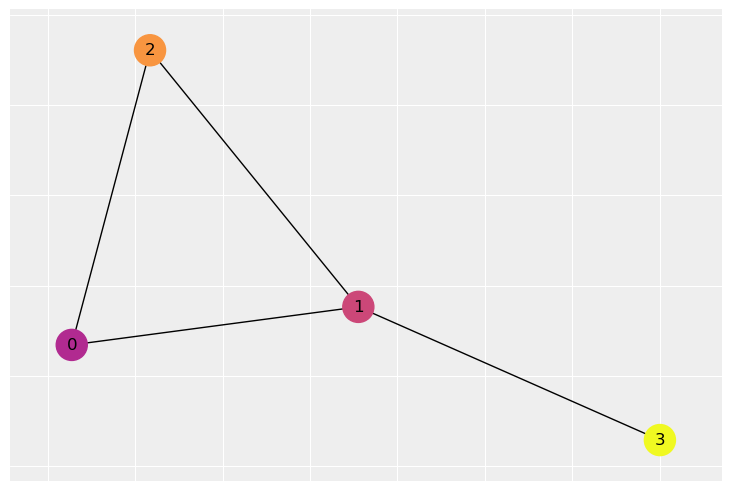

In [4]:
# adjacency matrix

W = np.array([[0, 1, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [0, 1, 0, 0]])

# plotting routine for graphs

G = nx.Graph(W)
colors = np.array([0.8, 1, 1.5, 2])
nx.draw_networkx(G, node_color=colors, vmin=0, vmax=2, node_size=500, cmap="plasma")

The adjacency matrix encodes which nodes are connected to which other nodes. If node i and j are connected, there will be a 1 at row i, column j. Otherwise, there will be a zero. For example, node 1 and 3 are connected. There is a 1 in the matrix at row 3, column 1. However node 3 is not connected to node 2, so there is a 0 at row 3 column 2. We have to, of course, remember python indexing. The first row is 0 and the last is 3. Adjacency matrices are also symmetrical - if Canada is adjacent to the United States, the United States is adjacent to Canada.

The density function for ICAR takes in an adjacency matrix `W`` and a variance $\sigma$. We usually assume $\sigma = 1$ and deal with variance in other ways so I'll ignore that first fraction for now.

$$f(\phi| W,\sigma) =
          -\frac{1}{2\sigma^{2}} \sum_{i\sim j} (\phi_{i} - \phi_{j})^2$$

Each $\phi_{i}$ is penalized based on the square distance from each of its neighbors. The notation $i \sim j$ indicates a sum over all the neighbors of $\phi_{i}$. 

So, for example, imagine that the intensity of the color represents the value of a variable at each node. Node 1 is connected to everyone. Node 1 and 0 have a fairly similar color so the penalty would be small. But node 2 has a pretty different color from node 1, so it would receive a large penalty. If we move our attention to node 3, it only has one neighbor and would receive just a single large penalty based on the distance from node 1. 

In this way, ICAR encodes the core assumption of spatial statistics - *nearby areas should be more similar to each other than distant areas*. The most likely outcome is a graph where every node has the same value. In this case, the square distance between neighbors is always zero. The more a graph experiences abrupt changes between neighboring areas, the lower the log density.

ICAR has a few other special features: it is contrained so all the $\phi$'s add up to zero. This also implies the mean of the $\phi$'s is zero. It can be helpful to think of ICAR values as similar to z-scores. They represent relative deviations centered around 0. ICAR is also typically only used as a sub-component of a larger model. Other parts of the model typically adjust the scale (with a variance parameter) or the location (with an intercept parameter). An accessible discussion of the math behind ICAR and its relationship to CAR can be found [here](https://mc-stan.org/users/documentation/case-studies/icar_stan.html) or in the academic paper version {cite:p}`morris2021bym`.

(bym-components)=
## The flexbility of random effects

One of the typical goals of statistical modeling is to partition the variance of the data into three categories: variance explained by the causes of interest, structured variance and unstructured variance. In our case, the ICAR model is meant to capture the (spatially) structured variance. Adding predictor variables can handle the first category. The BYM model approaches the third category with random effects, $\theta$. A random effect is a vector of random variables of length `n` where `n` is the number of areas. It is meant to capture all the remaining variance not explained by spatial or causal effects. 

Constructing a model that includes both structured and unstructured variance can be tricky. Naive approaches often run into issues of identifiability. Each component can, in principle, independently explain the variance. So the fitting algorithm might not be able to settle into a small neighborhood in the parameter space.

The BYM model is delicately designed to solve issues of identifiability. It uses a mixture distribution where the parameter $\rho$ controls the balance of structured to unstructured variance. The BYM model looks this:

$$\beta + \sigma(\sqrt{1 - \rho} \theta + \sqrt{\rho / \text{s}} \phi)$$

When $\rho$ is close to 1, most of the variance is spatially structured. When $\rho$ is close to 0, most of the variance is unstructured. 

$\sigma$ is a scale parameter shared by both $\theta$ and $\phi$. Both $\theta$ and $\phi$ are centered at zero and have a variance of 1. So they both function like z-scores. $\sigma$ can stretch or shrink the mixture of effects so it is appropriate for the actual data. $\beta$ is a shared intercept that recenters the mixture to fit the data. Finally, $\text{s}$ is the scaling factor. It is a constant computed from the adjacency matrix. It rescales the $\phi$'s so that they have the same expected variance as $\theta$. A more detailed discussion of why this works [appears below](#scaling-factor).

Fitting this model takes care of the challenge of partitioning variance into structure and unstructured components. The only challenge left is settling on predictor variables, a challenge that varies from case to case. {cite:t}`riebler2016intuitive` put forward this particular approach to the BYM model and offers more explanation of why this parameterization of the BYM model is both interpretable and identifiable while naive BYM models are often not.

# Demonstrating the BYM model on the New York City pedestrian accidents dataset

We'll demonstrate the BYM model on a dataset recording the number of traffic accidents involving youth pedestrians in New York City. The data is organized into roughly 2000 census tracts, providing our spatial structure. Our goal is to demonstrate that we can partition the variance into spatial and unstructured components.

(adjacency-map)=
## Setup the data

The spatial data comes in the form of an [edgelist](https://en.wikipedia.org/wiki/Edge_list). Beside adjacency matrices, edgelists are the other popular technique for representing areal data on computers. An edgelist is a pair of lists that stores information about the edges in a graph. Suppose that i and j are the names of two nodes. If node i and node j are connected, then one list will contain i and the other will contain j on the same row. For example, in the dataframe below, node 1 is connected to node 1452 as well as node 1721. 

In [5]:
try:
    df_edges = pd.read_csv(os.path.join("..", "data", "nyc_edgelist.csv"))
except FileNotFoundError:
    df_edges = pd.read_csv(pm.get_data("nyc_edgelist.csv"))

df_edges

,N,N_edges,node1,node2
0,1921,5461,1,1452
1,1921,5461,1,1721
2,1921,5461,2,3
3,1921,5461,2,4
4,1921,5461,2,5
...,...,...,...,...
5456,1921,5461,1918,1919
5457,1921,5461,1918,1921
5458,1921,5461,1919,1920
5459,1921,5461,1919,1921


To actually get our model running, however, we'll need to convert the edgelist to an adjacency matrix. The code below performs that task along with some other clean up tasks.

In [6]:
# convert edgelist to adjacency matrix

# extract and reformat the edgelist

nodes = np.stack((df_edges.node1.values, df_edges.node2.values))
nodes = nodes.T

# subtract one for python indexing

nodes = nodes - 1

# convert the number of nodes to a integer

N = int(df_edges.N.values[0])

# build a matrix of zeros to store adjacency
# it has size NxN where N is the number of
# areas in the dataset

adj = np.zeros((N, N))

# loop through the edgelist and assign 1
# to the location in the adjacency matrix
# to represent the edge
# this will only fill in the upper triangle
# of the matrix

for node in nodes:
    adj[tuple(node)] = 1

# add the transpose to make the adjacency
# matrix symmetrical

W_nyc = adj.T + adj

We'll compute the scaling factor. It will require a special function which is fairly involved. A proper explanation of the function would take us pretty far afield from the NYC case study so I'll leave {ref}`discussion of the scaling factor for later <scaling-factor>`.

In [7]:
def scaling_factor_sp(A):
    """Compute the scaling factor from an adjacency matrix.
    This function uses sparse matrix computations and is most
    efficient on sparse adjacency matrices. Used in the BYM2 model.
    The scaling factor is a measure of the variance in the number of
    edges across nodes in a connected graph.
    Only works for fully connected graphs. The argument for scaling
    factors is developed by Andrea Riebler, Sigrunn H. Sørbye,
    Daniel Simpson, Havard Rue in "An intuitive Bayesian spatial
    model for disease mapping that accounts for scaling"
    https://arxiv.org/abs/1601.01180"""

    # Computes the precision matrix in sparse format
    # from an adjacency matrix.

    num_neighbors = A.sum(axis=1)
    A = sparse.csc_matrix(A)
    D = sparse.diags(num_neighbors, format="csc")
    Q = D - A

    # add a small jitter along the diagonal

    Q_perturbed = Q + sparse.diags(np.ones(Q.shape[0])) * max(Q.diagonal()) * np.sqrt(
        np.finfo(np.float64).eps
    )

    # Compute a version of the pseudo-inverse

    n = Q_perturbed.shape[0]
    b = sparse.identity(n, format="csc")
    Sigma = spsolve(Q_perturbed, b)
    A = np.ones(n)
    W = Sigma @ A.T
    Q_inv = Sigma - np.outer(W * solve(A @ W, np.ones(1)), W.T)

    # Compute the geometric mean of the diagonal on a
    # precision matrix.

    return np.exp(np.sum(np.log(np.diag(Q_inv))) / n)


scaling_factor = scaling_factor_sp(W_nyc)
scaling_factor

0.7136574058611103

The first `.csv` file just has the spatial structure bits. The rest of the data comes seperately - here we'll pull in the number of accidents `y` and the population size of the census track, `E`. We'll use the population size as an offset - we should expect that more populated areas will have more accidents for trivial reasons. What is more interesting is something like the excess risk associated with an area.

In [8]:
try:
    df_nyc = pd.read_csv(os.path.join("..", "data", "nyc_traffic.csv"))
except FileNotFoundError:
    df_nyc = pd.read_csv(pm.get_data("nyc_traffic.csv"))

y = df_nyc.events_2001.values
E = df_nyc.pop_2001.values

# Most census tracts have huge populations
# but a handful have 0. We round
# those up to 10 to avoid triggering an error
# with the log of 0.

E[E < 10] = 10
log_E = np.log(E)
area_idx = df_nyc["nyc_tractIDs"].values
coords = {"area_idx": area_idx}

We can get a sense of the spatial structure by visualizing the adjacency matrix. The figure below only captures the relative position of the census tracks. It doesn't bother with the absolute position so it doesn't look like New York City. This representation highlights how the city is composed of several regions of uniformly connected areas, a few central hubs that have a huge number of connections, and then a few narrow corridors.

The map also shows there are number of hotspots where most of the accidents take place and they are spatially clustered. This is a good indication that a spatial autocorrelation model is an appropriate choice.

In [9]:
# build the positions of the nodes. We'll only
# generate the positions once so that we can
# compare visualizations from the data to
# the model predictions.
# I found that running spectral layout first
# and passing it to spring layout makes easy to read
# visualizations for large datasets.

G_nyc = nx.Graph(W_nyc)
pos = nx.spectral_layout(G_nyc)
pos = nx.spring_layout(G_nyc, pos=pos)

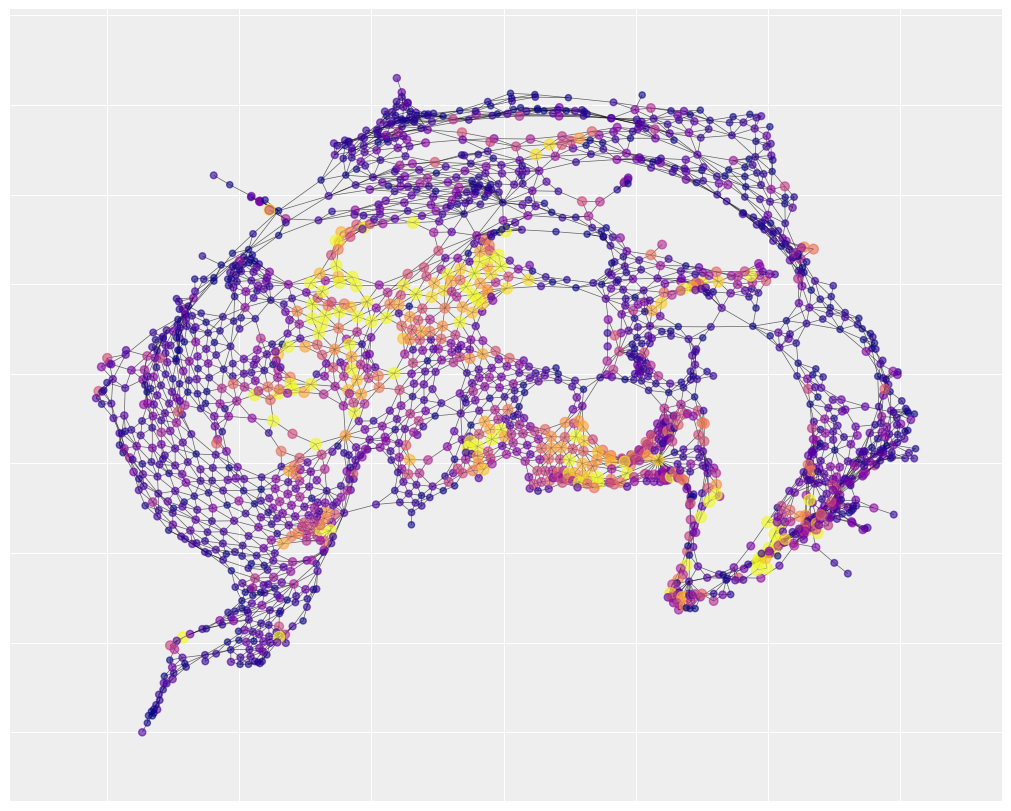

In [10]:
# the dispersion of the data is pretty high. Most areas have 0 accidents.
# one area has 300. Color-gradient based visualization doesn't work
# well under those conditions. So for the purpose of the color
# we'll cap the accidents at 30.

yz = y
yz[y > 30] = 30

# however, we'll also make the node size sensitive to the real
# number of accidents. So big yellow nodes have way more accidents
# than small yellow nodes.

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=yz,
    cmap="plasma",
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 1.5 * y,
)

## Specifying a BYM model with PyMC

All the parameters of the BYM were already introduced in {ref}`section 1 <bym-components>`. Now it's just a matter of assigning some priors. The priors on $\theta$ are picky - we need to assign a mean of 0 and a standard deviation 1 so that we can interpret it as comparable with $\phi$. Otherwise, the priors distributions afford the opportunity to incorporate domain expertise. In this problem, I'll pick some weakly informative priors.

Lastly, we'll use a Poisson outcome distribution. The number of traffic accidents is a count outcome and the maximium possible value is very large. To ensure our predictions remain positive, we'll exponentiate the linear model before passing it to the Poisson distribution.

In [11]:
with pm.Model(coords=coords) as BYM_model:

    # intercept
    beta0 = pm.Normal("beta0", 0, 1)

    # independent random effect
    theta = pm.Normal("theta", 0, 1, dims="area_idx")

    # spatially structured random effect
    phi = pm.ICAR("phi", W=W_nyc)

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)

    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(log_E + beta0 + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed=y)

## Sampling the model

In [12]:
# if you haven't installed nutpie, it's okay to to just delete
# 'nuts_sampler="nutpie"'. The default sampler took roughly 12 minutes on
# my machine.

with BYM_model:
    idata = pm.sample(2000, nuts_sampler="nutpie", random_seed=rng)

c:\Users\dsaun\Anaconda3\envs\spatial_pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
c:\Users\dsaun\Anaconda3\envs\spatial_pymc_env\Lib\site-packages\pymc\util.py:501: FutureWarning: The tag attribute observations is deprecated. Use model.rvs_to_values[rv] instead
  warnings.warn(


We can evaluate the sampler in several ways. First, it looks like all our chains converged. All parameters have an rhat value very close to one.

In [13]:
rhat = az.summary(idata).r_hat.values
sum(rhat > 1.03)

c:\Users\dsaun\Anaconda3\envs\spatial_pymc_env\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


0

Second, the trace plots on all the main parameters look stationary and well-mixed. They also reveal that the mean of rho is somewhere around 0.55, indicating that spatial effects are likely present in the data.

c:\Users\dsaun\Anaconda3\envs\spatial_pymc_env\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


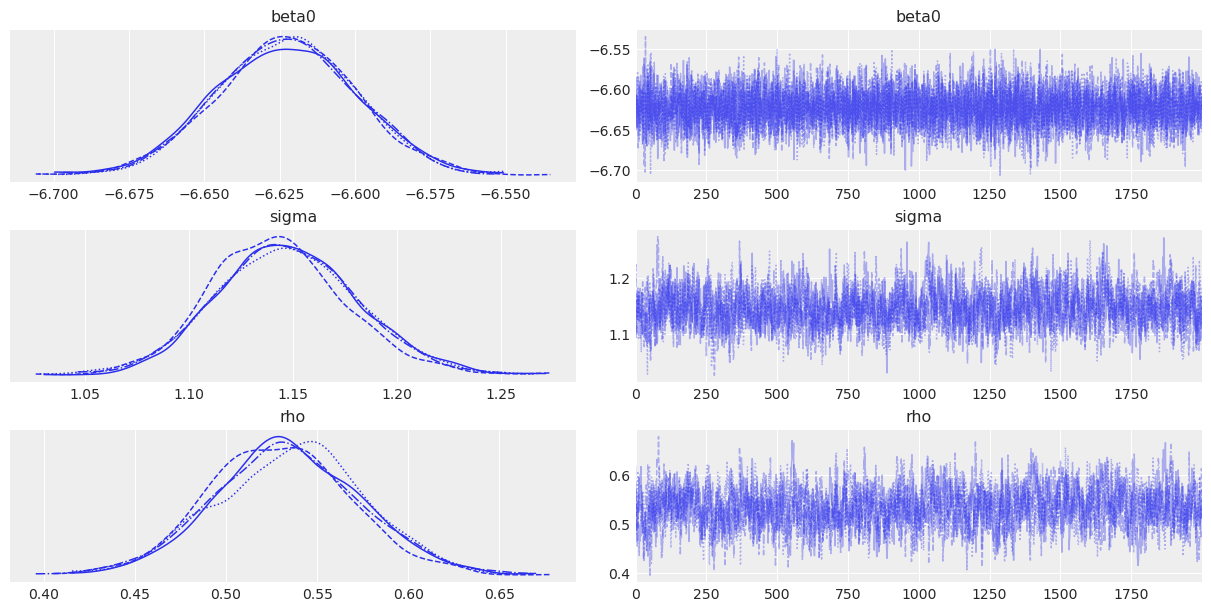

In [14]:
az.plot_trace(idata, var_names=["beta0", "sigma", "rho"])
plt.tight_layout();

## Posterior predictive checking

The payoff of all this work is that we can now visualize what it means to decompose the variance into spatial and unstructured parts. One way to make this vivid is to inspect each half of BYM mixture individually. We'll see what the model thinks NYC should look like if spatial effects were the only source of variance. Then we'll looks at the map as if only random effects were present.

We'll extract the means of several parameters to generate predictions. In the first case, we'll visualize only the predictions that come from the spatial component of the model. In other words, we are assuming $\rho = 1$.

In [15]:
phi_pred = idata.posterior.phi.mean(("chain", "draw"))
beta_pred = idata.posterior.beta0.mean(("chain", "draw"))
sigma_pred = idata.posterior.sigma.mean(("chain", "draw"))
y_predict = np.exp(log_E + (beta_pred + sigma_pred * (1 / scaling_factor) * phi_pred).values)

Then we'll overlay our predictions onto the same {ref}`adjacency map we built in early <adjacency-map>`. 

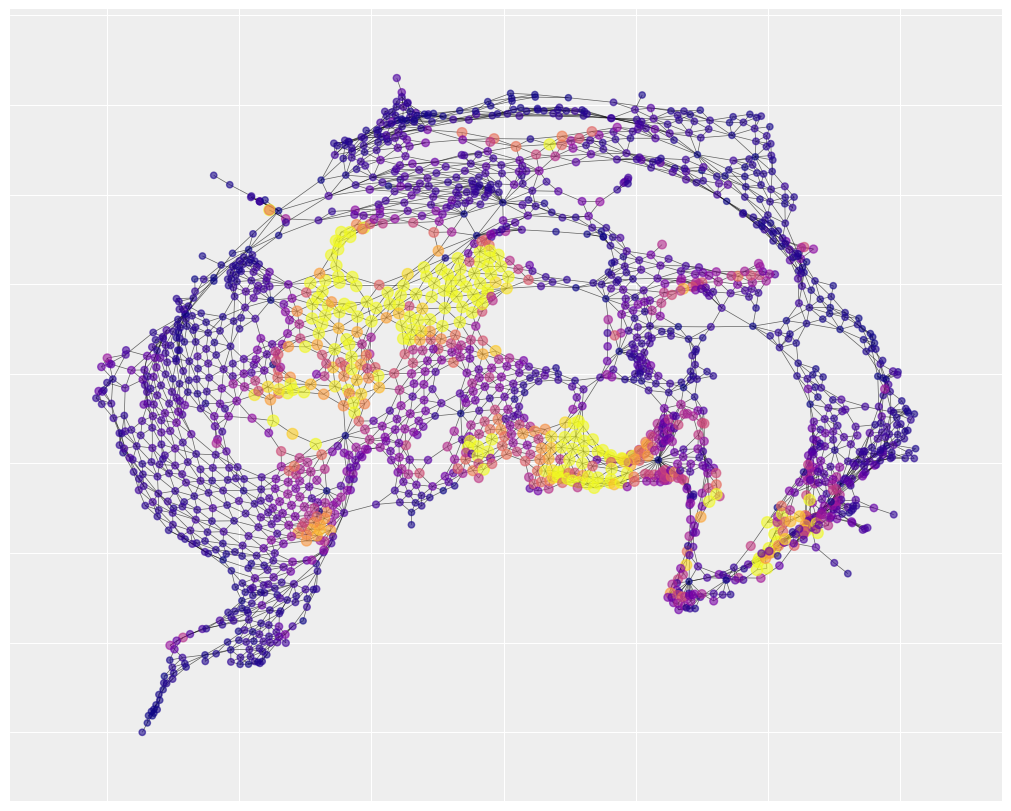

In [16]:
yz_predict = y_predict
yz_predict[y_predict > 30] = 30

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=yz_predict,
    cmap="plasma",
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 1.5 * y_predict,
)

The resulting picture is called *spatial smoothing*. Nearby areas tend to be very similar to each other, resulting in distinct neighborhoods of risk. In the dark purple regions, there is little variance and the number of predicted accidents is low, close to zero. 

Spatial smoothing is especially useful for forecasting. Imagine there was a low-accident tract surrounded in a high accident neighborhood. Suppose you wanted to predict where would have high accident numbers in the future so that you could target an intervention on those areas. Focusing only on the ring of tracts that had high accident counts in the past might be a mistake. The focal low-accident tract in the middle probably just had good luck in the past. In the future, that area will probably resemble its neighbors more than its past. Spatial smoothing relies on the same principle behind partial pooling - we can learn more by pooling information from nearby areas to correct for anomalies.

Finally, we might look at the unstructured variance by assuming $\rho = 0$. If our model managed to partition variance successfully, there should not be too many spatial clusters left over in the unstructured variance. Instead, variance should be scattered all over the map.

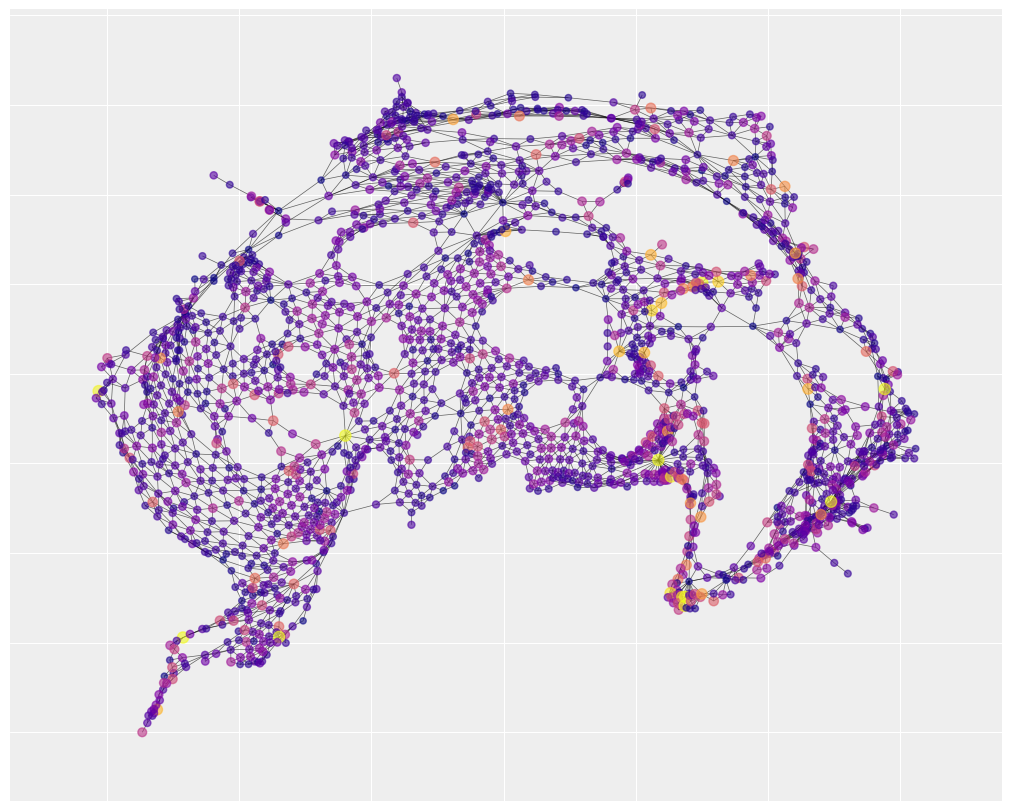

In [17]:
theta_pred = idata.posterior.theta.mean(("chain", "draw"))
y_predict = np.exp(log_E + (beta_pred + sigma_pred * theta_pred).values)

yz_predict = y_predict
yz_predict[y_predict > 30] = 30

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=yz_predict,
    cmap="plasma",
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 1.5 * y_predict,
)

(scaling-factor)=
# What does the scaling factor actually do?

Discussions of the BYM model often omit talking about the scaling factor in too much detail. There is good reason for this. If your main interest is in epidemiology, you don't really need to know about it. Users can allow it to just be a black box. The computation of the scaling factor also involves some pretty obscure ideas in linear algebra. I won't cover the computation here but I will try to provide a bit of intuition for what role it plays in the BYM model.

Take a look at these two graphs.

c:\Users\dsaun\Anaconda3\envs\spatial_pymc_env\Lib\site-packages\IPython\core\events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
c:\Users\dsaun\Anaconda3\envs\spatial_pymc_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


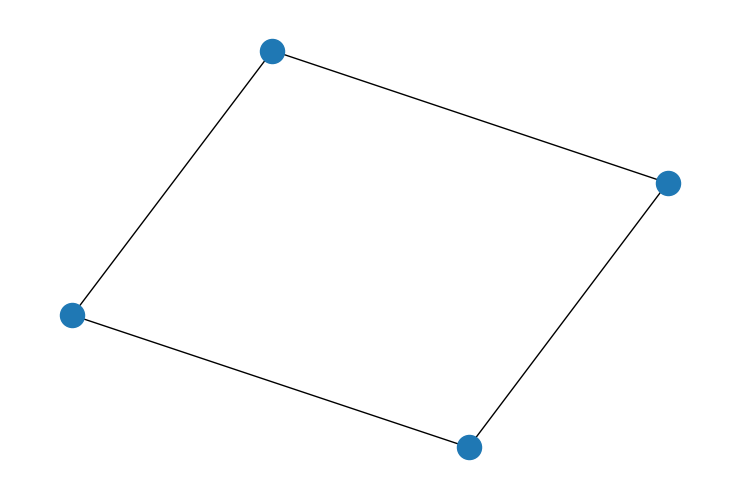

In [18]:
W1 = np.array([[0, 1, 1, 0], [1, 0, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]])

G = nx.Graph(W1)
nx.draw(G)

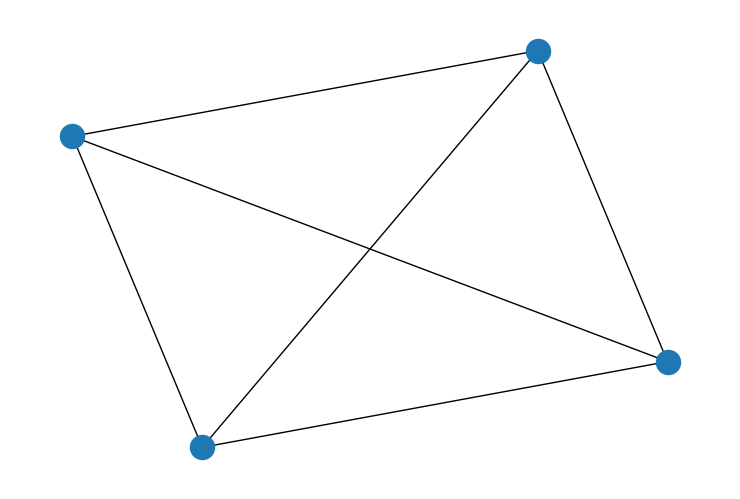

In [19]:
W2 = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])

G = nx.Graph(W2)
nx.draw(G)

If there is strong spatial covariance between the nodes, we should expect the first graph to allow for more variance than the second graph. In the second graph, every node exercises influence on every other node. So the resulting outcomes should relatively uniform.

The scaling factor is a measure of how much variance is implied by a particular adjacency matrix. If we compute the scaling factor for the two matrices above, it confirms our intuition. The first graph permits more variance than the second.

In [20]:
scaling_factor_sp(W1), scaling_factor_sp(W2)

(0.31249999534338707, 0.18749999767169354)

A second example can really underscore the point. These are two preferential attachment graphs - a few nodes have a lot of edges and the majority of nodes have very few edges. The only difference is the minimal number of edges. The first graph, every node gets at least one. In the second, each nodes has at least two.

scaling factor: 1.8773707481762945


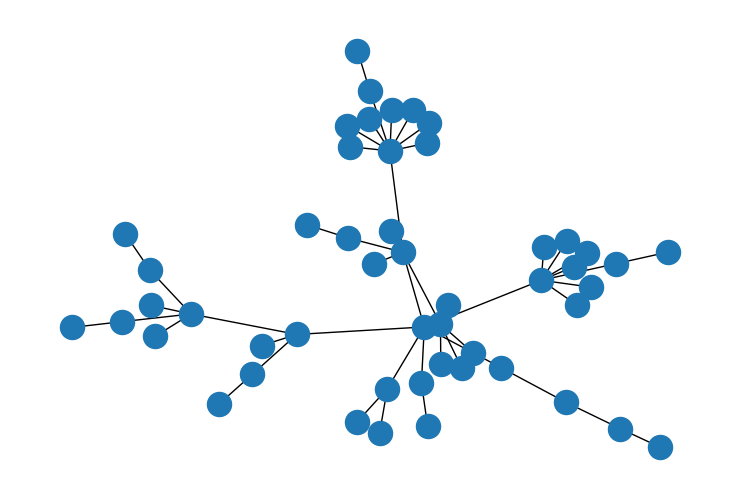

In [21]:
G = nx.barabasi_albert_graph(50, 1)
nx.draw(G)
W_sparse = nx.adjacency_matrix(G, dtype="int")
W = W_sparse.toarray()
print("scaling factor: " + str(scaling_factor_sp(W)))

scaling factor: 0.4107182238672077


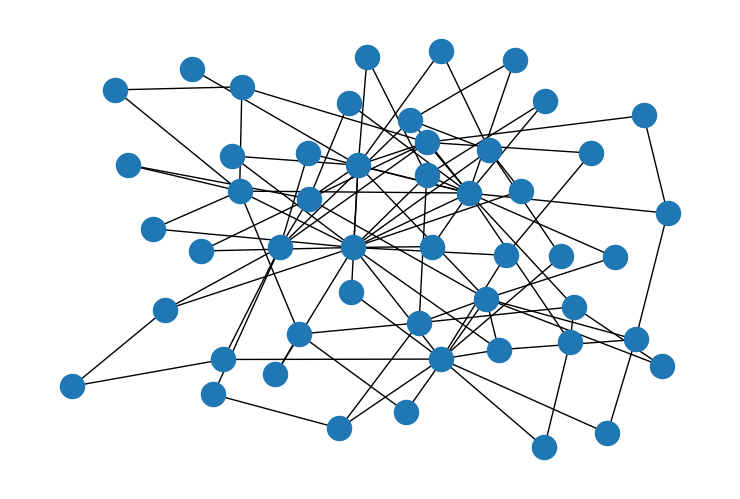

In [22]:
G = nx.barabasi_albert_graph(50, 2)
nx.draw(G)
W_sparse = nx.adjacency_matrix(G, dtype="int")
W = W_sparse.toarray()
print("scaling factor: " + str(scaling_factor_sp(W)))

The first graph has a much higher scaling factor because it is less uniformly connected. There is more opportunity for small pockets to form with distinctive traits. In the second graph, the regularity of connections moderates that opportunity. Again, the scaling factors confirm our intuition. 

This much clears up what the scaling factor measures. But why do we need to use it? Let's revisit the mathematical description of the BYM component:

$$\beta + \sigma(\sqrt{1 - \rho} \theta + \sqrt{\rho / \text{s}} \phi)$$

The goal of the BYM model is that we mix together two different types of random effects and then $\sigma$ provides the overall variance of the mixture. That means we need to be very careful about the individual variances of each random effect - they both need to equal approximately 1. It's easy to make sure the variance of $\theta \approx 1$. We can just specify that as part of the prior. Getting the variance of $\phi \approx 1$ is harder because the variance comes from data (the spatial structure), not from the prior. 

The scaling factor is the trick that ensures the variance of $\phi$ roughly equals one. When the variance implied by the spatial structure is quite small, say, less than one, dividing $\rho$ by the scaling factor will give some number greater than one. In other words, we expand the variance of $\phi$ until it equals one. Now all the other parameters will behave properly. $\rho$ represents a mixture between two similar things and $\sigma$ represents the joint variance from random effects.

A final way to understand the purpose of the scaling factor is to imagine what would happen if we didn't include it. Suppose the graph implied very large variance, like the first preferential attachment graph above. In this case, the mixture parameter, $\rho$, might pull in more of $\phi$ because the data has a lot of variance and the model is searching for variance wherever it can find to explain it. But that makes the intepretation of the results challenging. Did $\rho$ gravitate towards $\phi$ because there is actually a strong spatial structure? Or because it had higher variance than $\theta$? We cannot tell unless we rescale the $\phi$.

# Authors

* Authored by Daniel Saunders in August, 2023 ([pymc-examples#566](https://github.com/pymc-devs/pymc-examples/pull/566)).

# References 

:::{bibliography}
:filter: docname in docnames 
:::

# Watermark

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Wed Aug 23 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.8.0

xarray: 2022.12.0

pandas    : 1.5.2
arviz     : 0.14.0
numpy     : 1.24.3
scipy     : 1.10.0
pymc      : 5.7.2+16.g9ee5d84b
pytensor  : 2.14.2
networkx  : 3.0
nutpie    : 0.7.0
matplotlib: 3.6.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::